In [1]:
import numpy as np
from numpy import cos, sin, pi

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sympy as sp

In [12]:
# list of DH parameters
# Structure is d, theta, a, alpha in each row

# The theta angles are also referred to as qi

# Tells the code how many joint values to expect
DOF = 6

q1, q2, q3, q4, q5, q6 = sp.symbols('q1 q2 q3 q4 q5 q6')

# Value of pi from the symbolic library for convenience
spi = sp.pi

# Define DH table
d0 = 10.95
r2 = 17.9128
d3 = 11.2064
d4 = d3
d5 = 4.2

DH_params = []

DH_params.append([d0,q1,0 ,-spi/2])
DH_params.append([ 0,q2,r2,     0])
DH_params.append([ 0,q3,0 , spi/2])
DH_params.append([d3,q4,0 , spi/2])
DH_params.append([d4,q5,0 ,-spi/2])
DH_params.append([d5,q6,0 ,     0])

DH_params

[[10.95, q1, 0, -pi/2],
 [0, q2, 17.9128, 0],
 [0, q3, 0, pi/2],
 [11.2064, q4, 0, pi/2],
 [11.2064, q5, 0, -pi/2],
 [4.2, q6, 0, 0]]

In [13]:
# Using the combined DH transformation matrix
def DH_trans_matrix(params):
    
    d, theta, a, alpha = (params[0], params[1], params[2], params[3])
    
    mat = sp.Matrix([[sp.cos(theta), -1*sp.sin(theta)*sp.cos(alpha), sp.sin(theta)*sp.sin(alpha),    a*sp.cos(theta)],
                    [sp.sin(theta), sp.cos(theta)*sp.cos(alpha),    -1*sp.cos(theta)*sp.sin(alpha), a*sp.sin(theta)],
                    [0,             sp.sin(alpha),                  sp.cos(alpha),                  d],
                    [0,             0,                              0,                              1]])
    
    return mat

In [14]:
# Get the transformations from the origin to each of the joints and the end effector
def joint_transforms(DH_params):
    transforms = []

    transforms.append(sp.eye(4)) #Assuming the first first joint is at the origin

    for el in DH_params:

        transforms.append(DH_trans_matrix(el))

    return transforms

In [15]:
# To get the jacobain we can use the cross product method since we have all of the transformations

# Get the total transformation to the end effector
# This function gives the symbolic expression for the jacobian
def jacobian_expr(DH_params):

    transforms = joint_transforms(DH_params)

    trans_EF = transforms[0]

    for mat in transforms[1:]:

        trans_EF = trans_EF * mat

    pos_EF = trans_EF[0:3,3]

    J = sp.zeros(6, DOF)

    for joint in range(DOF):

        trans_joint = transforms[0]

        for mat in transforms[1:joint+1]:

            trans_joint = trans_joint*mat

        z_axis = trans_joint[0:3,2]

        pos_joint = trans_joint[0:3,3]

        Jv = z_axis.cross(pos_EF - pos_joint)

        Jw = z_axis

        J[0:3,joint] = Jv
        J[3:6,joint] = Jw

    J = sp.simplify(J)
    return J

In [16]:
# This function evaluates a symbolic jacobian expression using provided joint angles
def jacobian_subs(joints, jacobian_sym):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    J_l = jacobian_sym
    
    J_l = J_l.subs(q1, joints[0])
    J_l = J_l.subs(q2, joints[1])
    J_l = J_l.subs(q3, joints[2])
    J_l = J_l.subs(q4, joints[3])
    J_l = J_l.subs(q5, joints[4])
    J_l = J_l.subs(q6, joints[5])
    
    return J_l

In [17]:
# Verify the two previous functions

# If you're trying to implement the jacobian, you can just take the symbolic jacobian that's printed and hard
# code that into your model

jacobian_symbolic = jacobian_expr(DH_params)

jacobian_symbolic

Matrix([
[-11.2064*sin(q1)*sin(q4)*cos(q2 + q3) + 4.2*sin(q1)*sin(q5)*cos(q4)*cos(q2 + q3) - 4.2*sin(q1)*sin(q2 + q3)*cos(q5) - 11.2064*sin(q1)*sin(q2 + q3) - 17.9128*sin(q1)*cos(q2) + 4.2*sin(q4)*sin(q5)*cos(q1) + 11.2064*cos(q1)*cos(q4), (-17.9128*sin(q2) - 11.2064*sin(q4)*sin(q2 + q3) + 4.2*sin(q5)*sin(q2 + q3)*cos(q4) + 4.2*cos(q5)*cos(q2 + q3) + 11.2064*cos(q2 + q3))*cos(q1), (-11.2064*sin(q4)*sin(q2 + q3) + 4.2*sin(q5)*sin(q2 + q3)*cos(q4) + 4.2*cos(q5)*cos(q2 + q3) + 11.2064*cos(q2 + q3))*cos(q1), -11.2064*sin(q1)*sin(q4) + 4.2*sin(q1)*sin(q5)*cos(q4) + 4.2*sin(q4)*sin(q5)*cos(q1)*cos(q2 + q3) + 11.2064*cos(q1)*cos(q4)*cos(q2 + q3),  4.2*sin(q1)*sin(q4)*cos(q5) - 4.2*sin(q5)*sin(q2 + q3)*cos(q1) - 4.2*cos(q1)*cos(q4)*cos(q5)*cos(q2 + q3),                                                                                        0],
[ 4.2*sin(q1)*sin(q4)*sin(q5) + 11.2064*sin(q1)*cos(q4) + 11.2064*sin(q4)*cos(q1)*cos(q2 + q3) - 4.2*sin(q5)*cos(q1)*cos(q4)*cos(q2 + q3) + 4.2*sin(q2 + 

In [ ]:
def trans_EF_eval(joints, DH_params):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    transforms = joint_transforms(DH_params)

    trans_EF = transforms[0]

    for mat in transforms[1:]:

        trans_EF = trans_EF * mat
    
    trans_EF_cur = trans_EF
    
    trans_EF_cur = trans_EF_cur.subs(q1, joints[0])
    trans_EF_cur = trans_EF_cur.subs(q2, joints[1])
    trans_EF_cur = trans_EF_cur.subs(q3, joints[2])
    trans_EF_cur = trans_EF_cur.subs(q4, joints[3])
    trans_EF_cur = trans_EF_cur.subs(q5, joints[4])
    trans_EF_cur = trans_EF_cur.subs(q6, joints[5])
    
    return trans_EF_cur

In [9]:
# This is just for visualizing the robot

def plot_pose(joints, DH_params):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
        
    transforms = joint_transforms(DH_params)

    trans_EF = trans_EF_eval(joints, DH_params)
    
    pos_EF = trans_EF[0:3,3]
    
    xs = []
    ys = []
    zs = []
    
    J = sp.zeros(6, DOF)

    for joint in range(DOF):

        trans_joint = transforms[0]

        for mat in transforms[1:joint+1]:

            trans_joint = trans_joint*mat

        pos_joint = trans_joint[0:3,3]
        
        pos_joint = pos_joint.subs(q1, joints[0])
        pos_joint = pos_joint.subs(q2, joints[1])
        pos_joint = pos_joint.subs(q3, joints[2])
        pos_joint = pos_joint.subs(q4, joints[3])
        pos_joint = pos_joint.subs(q5, joints[4])
        pos_joint = pos_joint.subs(q6, joints[5])
        
        xs.append(pos_joint[0])
        ys.append(pos_joint[1])
        zs.append(pos_joint[2])
        
    xs.append(pos_EF[0])
    ys.append(pos_EF[1])
    zs.append(pos_EF[2])
            
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_xlim3d(-60,60)
    ax.set_ylim3d(-60,60)
    ax.set_zlim3d(0, 120)
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    ax.plot(xs, ys, zs)

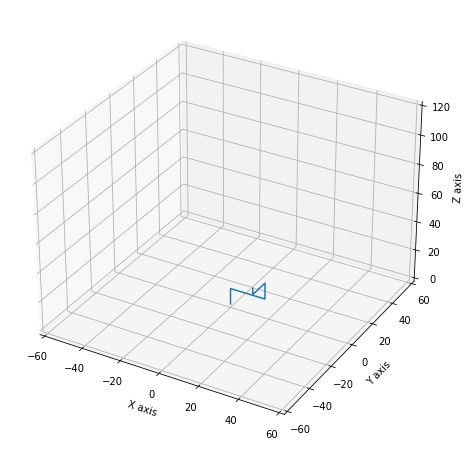

In [10]:
# This is just for testing the robot plotting mechanism

joints = [0, 0, 0, 0, 0, 0]

plot_pose(joints, DH_params)